In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [18]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [61]:
## Making smaller data set for Hierarchical Clustering
books_small = books[:300]

books_small

,wid,fid,title,author,date,genres,summary,genre
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",Novel
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,Novel
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...,
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,Fantasy
...,...,...,...,...,...,...,...,...
295,70850,/m/0jb7s,Smith of Wootton Major,J. R. R. Tolkien,,"{""/m/01hmnh"": ""Fantasy"", ""/m/02xlf"": ""Fiction""...",The village of Wootton Major was well-known a...,Fantasy
296,71029,/m/0jc4c,The Tie That Binds,Kent Haruf,,,"In 1896, newlyweds Roy and Ada Goodnough leav...",
297,71290,/m/0jd3p,"England, England",Julian Barnes,1998,"{""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf...","England, England is divided into three parts ...",
298,71416,/m/0jdh5,Dune,Frank Herbert,1965,"{""/m/0594kx"": ""Conspiracy fiction"", ""/m/06n90""...",Padishah Emperor Shaddam IV of House Corrino ...,Science Fiction


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [20]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape


(8954, 5)

In [21]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()


,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(genre_books.summary).toarray()
y = genre_books.genre

len(vectorizer.get_feature_names())

88356

### Hierarchical Clustering method

#### By clustering a small sample data from the main one, it is easier to visualize the book data and which way to group it. In this case they are based on title and author 

In [53]:
dist = pdist(X_small, 'euclidean') 
linkage_matrix = linkage(dist, method = 'ward') 

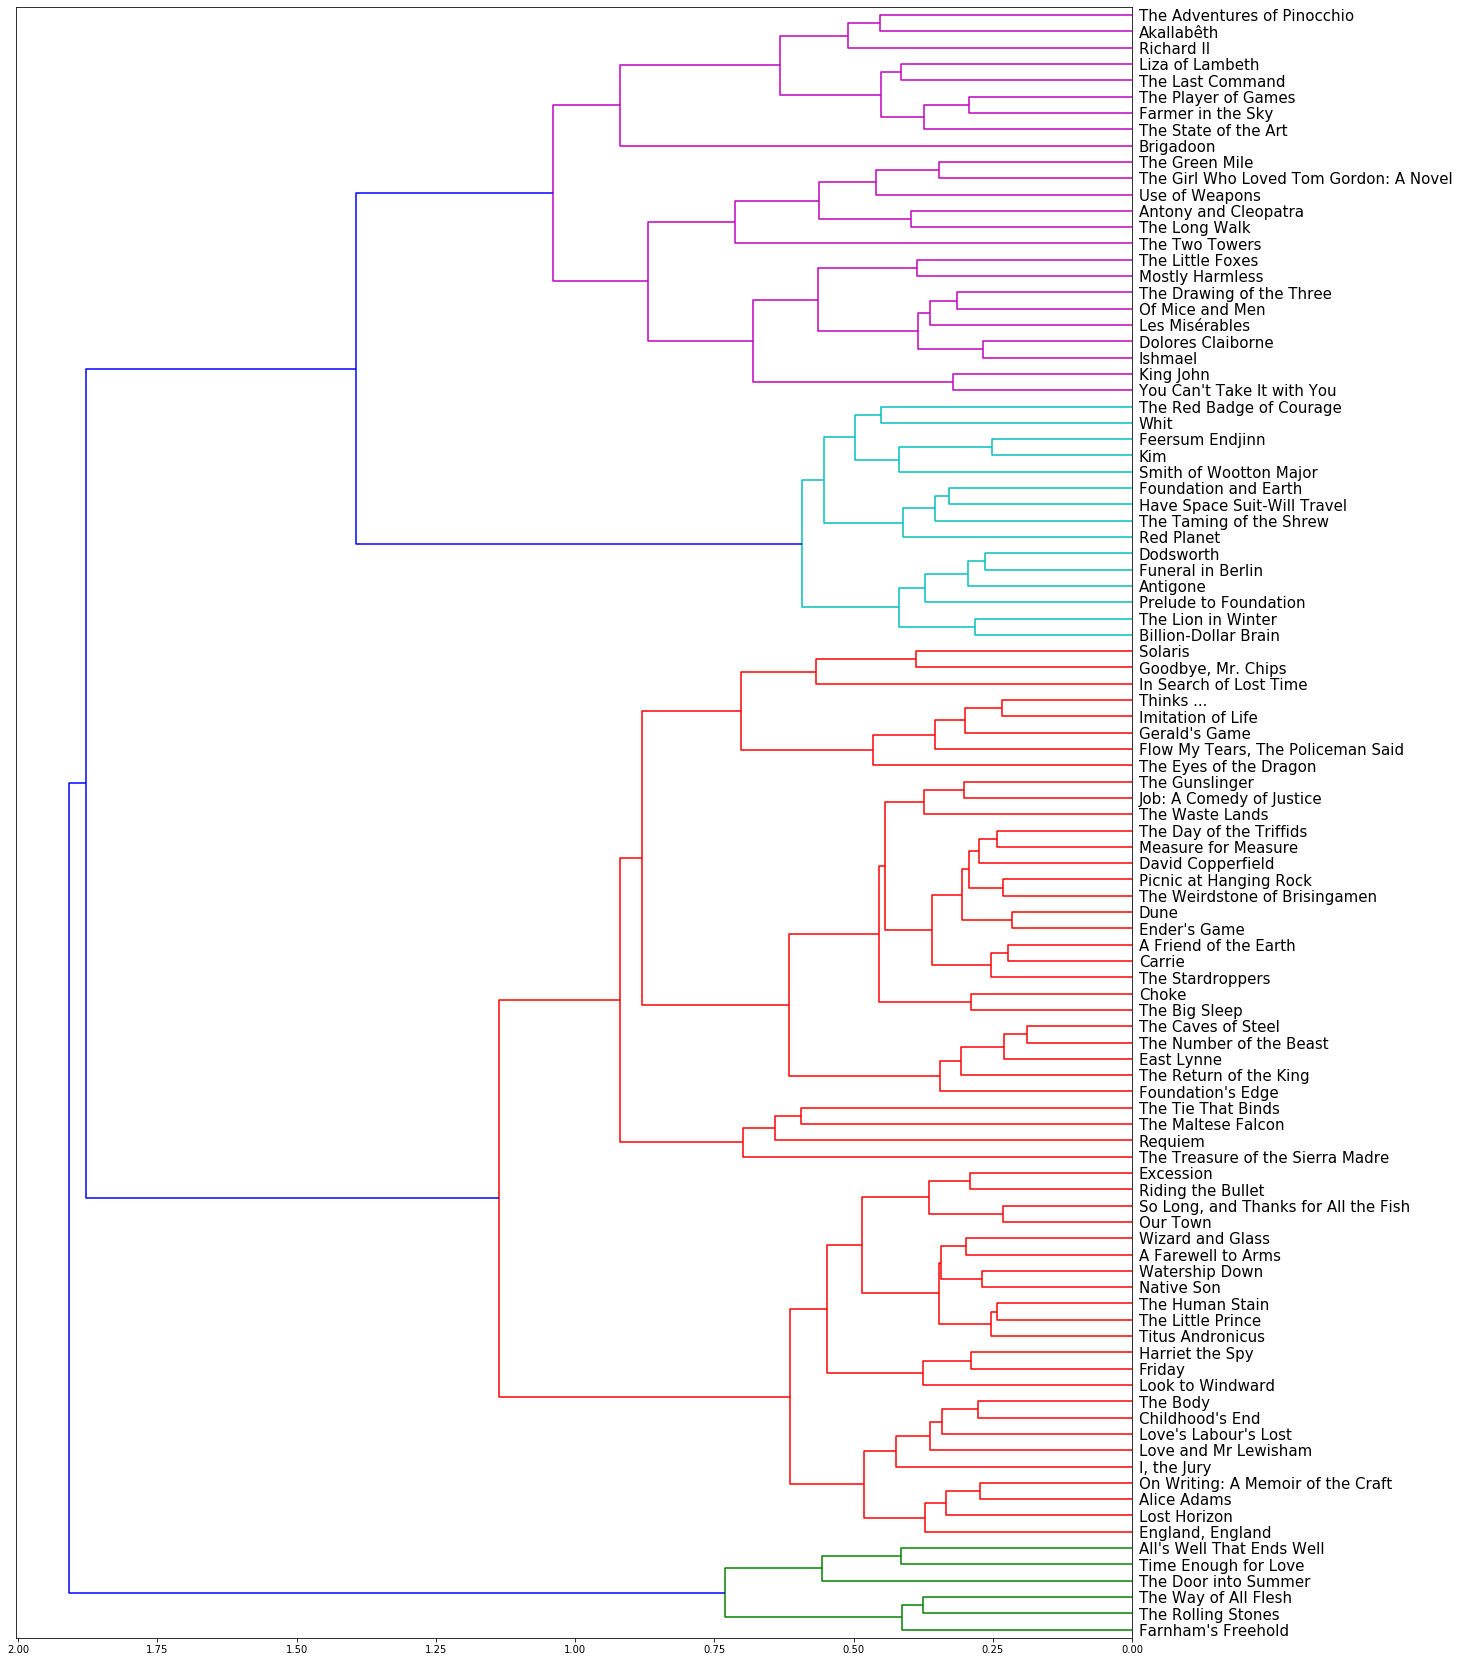

In [62]:
## Cluster based on title 
plt.figure(figsize=(20,30)) 
dendrogram(linkage_matrix, labels = list(books_small.title), orientation = 'left', leaf_font_size = 15)
plt.show() 

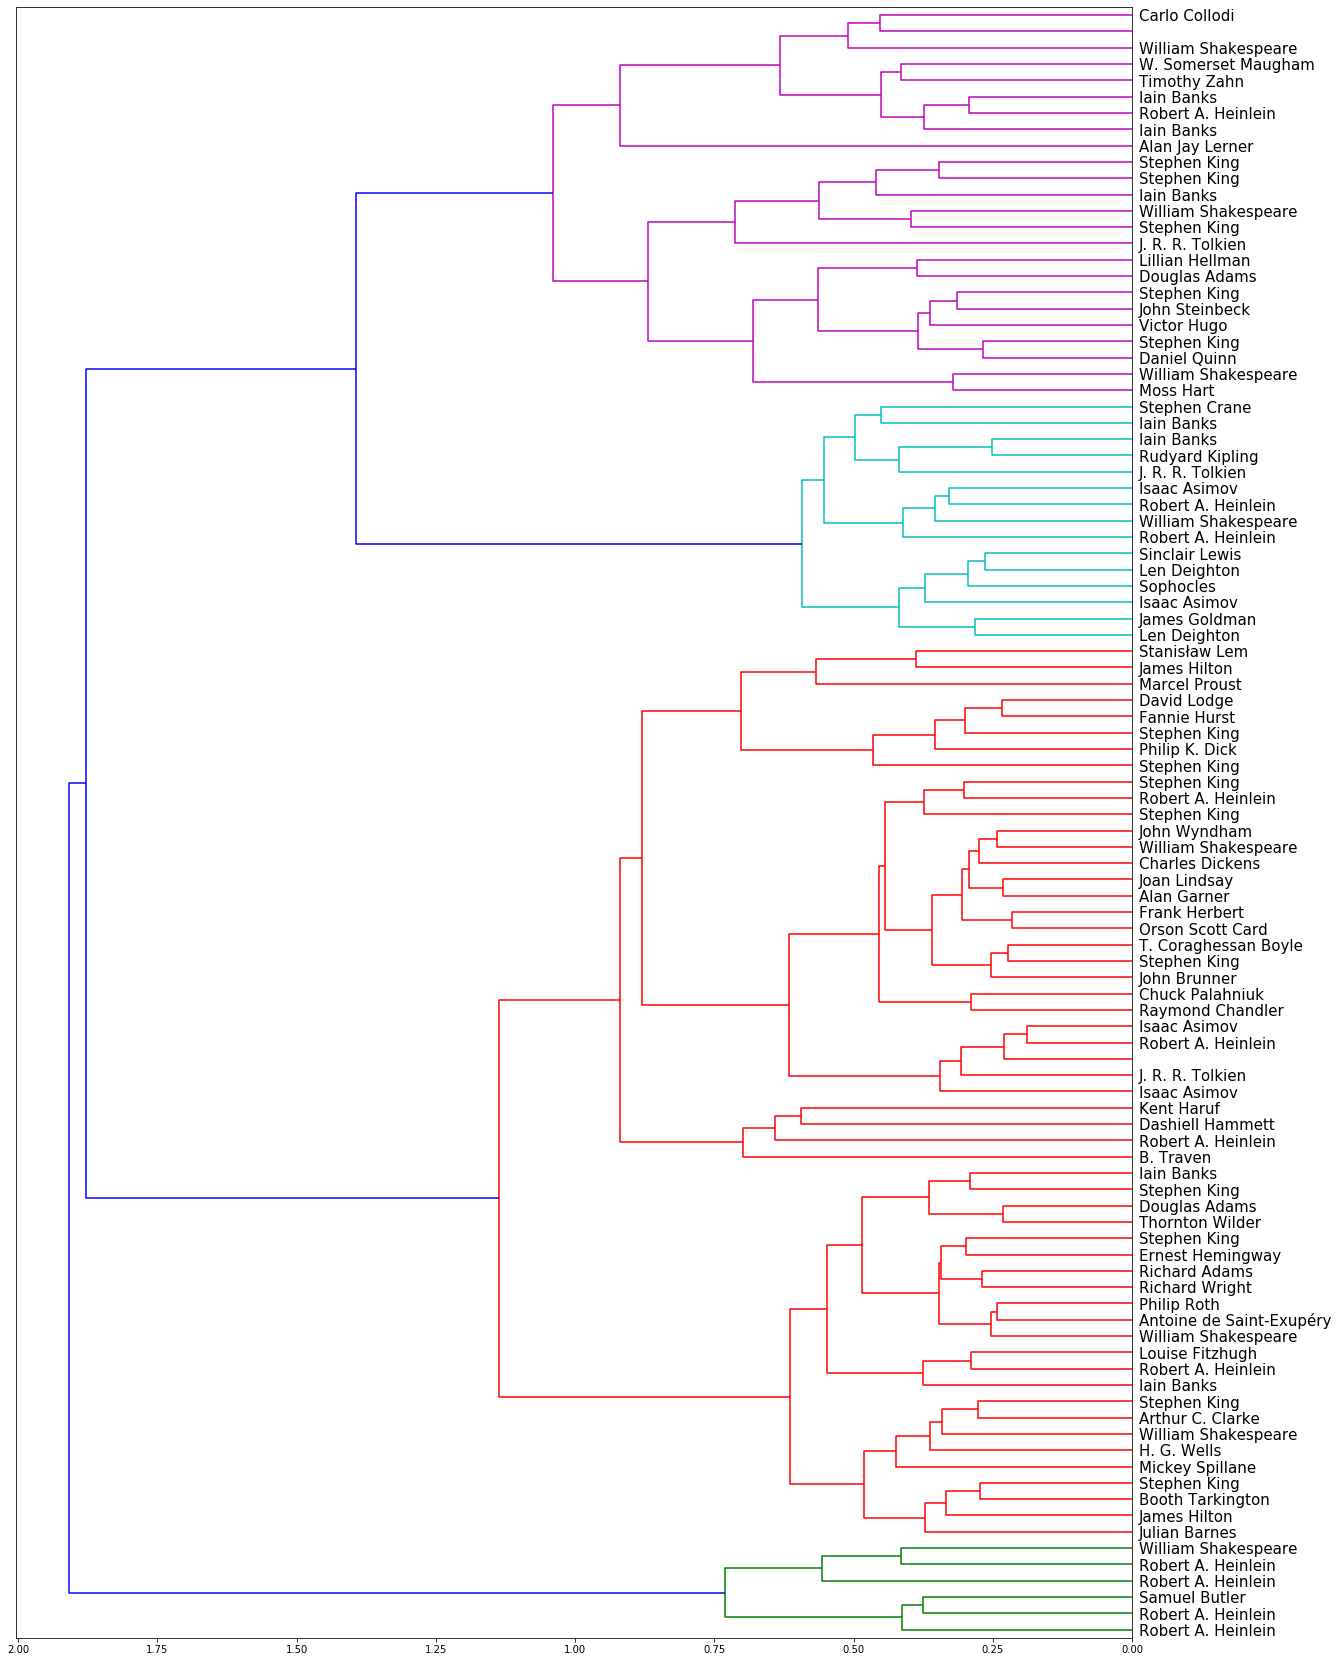

In [63]:
## Cluster based on author name
plt.figure(figsize=(20,30)) 
dendrogram(linkage_matrix, labels = list(books_small.author), orientation = 'left', leaf_font_size = 15)
plt.show() 

## Model Training

Then, train two predictive models from the given data set.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification

#Splitting data for training and testing for KNN
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42)

#Splitting data for training and testing for NB 
x1, y1 = make_classification(n_samples=50, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                           weights=None, flip_y=0.01, class_sep=0.5, hypercube=True,
                           shift=0.0, scale=1.0, shuffle=True, random_state=42)

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size= .25, random_state=42)

#Creating model 
### using KNN
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(x_train, y_train)

### using GaussianNB 
gnb = GaussianNB()
gnb.fit(x1_train, y1_train)


GaussianNB(priors=None, var_smoothing=1e-09)

## Model Evaluation

Finally, evaluate and compare the learned predictive models.

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('\nPerformance Metric report: \n', classification_report(y_test, y_pred))

Confusion Matrix: 
 [[ 80  34  19  79  17]
 [ 27 254  12 123  44]
 [ 17  30 130  87  15]
 [ 55  50  36 281  42]
 [ 17  54  10 117 161]]

Performance Metric report: 
                        precision    recall  f1-score   support

Children's literature       0.41      0.35      0.38       229
              Fantasy       0.60      0.55      0.58       460
              Mystery       0.63      0.47      0.53       279
                Novel       0.41      0.61      0.49       464
      Science Fiction       0.58      0.45      0.50       359

             accuracy                           0.51      1791
            macro avg       0.52      0.48      0.50      1791
         weighted avg       0.53      0.51      0.51      1791



In [47]:
print('Confusion Matrix: \n', confusion_matrix(y1_test, y1_pred))
print('\nPerformance Metric report: \n', classification_report(y1_test, y1_pred))

Confusion Matrix: 
 [[4 0 0]
 [0 2 0]
 [1 1 2]]

Performance Metric report: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.82      0.83      0.79        10
weighted avg       0.85      0.80      0.78        10



In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#predict testing data
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Testing accuracy KNN is: ', accuracy)

y1_pred = gnb.predict(x1_test)
accuracy1 = accuracy_score(y1_pred, y1_test)
print('Testing accuracy NB is: ', accuracy1)


Testing accuracy KNN is:  0.5058626465661642
Testing accuracy NB is:  0.8461538461538461


### We can see that the accuracy for KNN is only around 50.5% which is not really high and can hardly predict any variable. 

### Meanwhile, the accuracy for NB is much higher than that of KNN by nearly 35%. Therefore Naive Bayes model is the superior one for this data. 

In [82]:
clf_gnb = GaussianNB() 
clf_knn = KNeighborsClassifier(n_neighbors=13)

scores = cross_val_score(clf_gnb, x, y, scoring = 'accuracy', cv = 5)
print("GNB accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n" 
      % (scores.min(), scores.max(), scores.mean(), scores.std())) 
scores_gnb = scores

scores = cross_val_score(clf_knn, x, y, scoring = 'accuracy', cv = 10)
print("KNN accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n" 
      % (scores.min(), scores.max(), scores.mean(), scores.std())) 
scores_knn = scores


KeyboardInterrupt: 